In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.mixture import GaussianMixture

from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u

In [3]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

In [4]:
def extract_obs_data(hdul):
    # first do quality cuts
    no_starflag = hdul[1].data.STARFLAG == 0
    good_snr = hdul[1].data.SNR > 200
    good_vscatter = hdul[1].data.VSCATTER < 1
    good_parallax = hdul[1].data.GAIAEDR3_PARALLAX/hdul[1].data.GAIAEDR3_PARALLAX_ERROR > 1
    good_logg = np.logical_and(hdul[1].data.LOGG < 3.5, hdul[1].data.LOGG_ERR < 0.2)
    
    aspcap_keys = np.logical_and(no_starflag, good_snr)
    aspcap_keys = np.logical_and(aspcap_keys, good_vscatter)
    aspcap_keys = np.logical_and(aspcap_keys, good_parallax)
    aspcap_keys = np.logical_and(aspcap_keys, good_logg)
    
    # now get SN stars based on Lz
    ra = hdul[1].data.RA * u.degree
    dec = hdul[1].data.DEC * u.degree
    distance = (hdul[1].data.GAIAEDR3_PARALLAX*u.mas).to(u.pc, u.parallax())
    pm_ra = hdul[1].data.GAIAEDR3_PMRA * u.mas/u.yr
    pm_dec = hdul[1].data.GAIAEDR3_PMDEC * u.mas/u.yr
    radial_velocity=hdul[1].data.GAIAEDR3_DR2_RADIAL_VELOCITY * u.km/u.s
    
    cosdec = np.cos(hdul[1].data.DEC * np.pi/180)
    pm_ra_cosdec = pm_ra
    
    c1 = coord.SkyCoord(ra=ra, dec=dec,
                    distance=distance,
                    pm_ra_cosdec=pm_ra_cosdec,
                    pm_dec=pm_dec,
                    radial_velocity=radial_velocity,
                    frame='icrs')
    
    gc1 = c1.transform_to(coord.Galactocentric)
    
    Lz = gc1.x * gc1.v_y - gc1.y * gc1.v_x
    Lz = Lz.to(u.kpc*u.km/u.s).value
    Lzsun = -8 * 220
    key = np.abs(Lz/Lzsun - 1) < 0.1
    
    in_SN = np.logical_and(key, aspcap_keys)
    
    logFeH = hdul[1].data.FE_H
    logMgFe = hdul[1].data.MG_FE

    out = {}
    out['logFeH'] = logFeH[in_SN]
    out['logMgFe'] = logMgFe[in_SN]
    
    return out

hdul = fits.open('../../data/allStar-dr17-synspec_rev1.fits')
obsdata = extract_obs_data(hdul)

In [5]:
def construct_gmm(dat, logFeH0=0, dlogFeH=0.1, no_SN=False):
    """
    Analyze peaks in the logMgFe data and determine if the data prefers 2 modes over 1 mode.

    Parameters:
        dat (dict): Dictionary containing simulated data.
        logFeH0 (float): Central logFeH value to filter data around.
        dlogFeH (float): Range of logFeH to filter data.
        no_SN (bool): If True, exclude SN filtering.

    Returns:
        preferred_gmm (GaussianMixture): The GMM model (1 or 2 modes) preferred by BIC.
        prefers_two_modes (bool): True if BIC suggests 2 modes are preferred over 1 mode.
        bic_diff (float): Difference in BIC between the 1-mode and 2-mode models.
    """
    # Extract the data
    logFeH = dat['logFeH']
    logMgFe = dat['logMgFe']
    
    if not no_SN:
        logFeH = logFeH[dat['in_SN']]
        logMgFe = logMgFe[dat['in_SN']]
    
    # Filter data based on logFeH
    key = np.logical_and(logFeH > logFeH0 - dlogFeH / 2, logFeH < logFeH0 + dlogFeH / 2)
    data = logMgFe[key].reshape(-1, 1)

    # Fit Gaussian Mixture Models with 1 and 2 components
    gmm_1 = GaussianMixture(n_components=1, random_state=0)
    gmm_2 = GaussianMixture(n_components=2, random_state=0)
    gmm_1.fit(data)
    gmm_2.fit(data)

    # Compute BIC for both models
    bic_1 = gmm_1.bic(data)
    bic_2 = gmm_2.bic(data)
    bic_diff = bic_1 - bic_2  # Positive if 2 modes are preferred

    # Determine which GMM is preferred
    prefers_two_modes = bic_diff > 0

    return gmm_1, gmm_2, prefers_two_modes, bic_diff


def calculate_overlap(mean1, std1, mean2, std2):
    """
    Calculate the overlap between two Gaussian distributions.
    
    Parameters:
        mean1, std1: Mean and standard deviation of the first Gaussian.
        mean2, std2: Mean and standard deviation of the second Gaussian.
        
    Returns:
        overlap (float): The overlap between the two distributions.
    """
    def pdf1(x):
        return norm.pdf(x, loc=mean1, scale=std1)
    
    def pdf2(x):
        return norm.pdf(x, loc=mean2, scale=std2)
    
    def min_pdf(x):
        return np.minimum(pdf1(x), pdf2(x))
    
    # Integrate the minimum of the two PDFs
    overlap, _ = quad(min_pdf, -np.inf, np.inf)
    return overlap

def bimodality_metric(gmm, t=0.1, k=20):
    """
    Calculate a bimodality metric based on the ratio of the less prominent mode's peak 
    to the trough between the two modes, adjusted by the ratio of mode weights.
    
    Parameters:
        gmm: A fitted GaussianMixture object from sklearn.
    
    Returns:
        bimodality_score (float): The calculated bimodality metric.
    """
    def weight_penalty(w2, t, k):
        return 1 / (1 + np.exp(-k * (w2 - t)))
    
    if len(gmm.means_.flatten())==1:
        return 0.0
    
    # Extract GMM parameters
    means = gmm.means_.flatten()
    variances = gmm.covariances_.flatten()
    weights = gmm.weights_

    # Ensure components are ordered by mean
    order = np.argsort(means)
    means = means[order]
    variances = variances[order]
    weights = weights[order]

    # Calculate the peaks (heights of the modes)
    peaks = weights / np.sqrt(2 * np.pi * variances)
    less_prominent_peak = min(peaks)

    # Find the trough: point between means where the GMM density is minimized
    x_trough = np.linspace(means[0], means[1], 1000)
    densities = np.exp(gmm.score_samples(x_trough.reshape(-1, 1)))
    trough_density = densities.min()

    # Compute the weight ratio (smaller weight divided by larger weight)
    # weight_ratio = min(weights) / max(weights)
    # weight_ratio = 1

    # Compute the bimodality metric, scaling by the weight ratio
    # bimodality_score = (less_prominent_peak / trough_density) * weight_ratio
    
    bimodality_score = np.abs(means[1] - means[0]) / np.sqrt(np.sum(variances))
    bimodality_score *= weight_penalty(min(weights), t, k)
    
    # bimodality_score = np.abs(means[0] - means[1])
    return bimodality_score

def get_bimodality_score_from_MgFe(MgFe):
    dat = {}
    dat['logMgFe'] = MgFe
    dat['logFeH'] = np.full_like(MgFe, 0)
    _, gmm, _, _ = construct_gmm(dat, no_SN=True)
    return bimodality_metric(gmm)

In [16]:
import numpy as np

def sfr(t, sfr0=5, gap=None, burst=None, tmax=None, tstart=0):
    # Initialize the output variable
    if np.isscalar(t):
        ans = sfr0  # For scalar input, set directly
    else:
        ans = np.full_like(t, sfr0)  # For array input, create array of sfr0

    # Apply the gap logic
    if gap is not None:
        if np.isscalar(t):
            # Handle scalar input
            if np.abs(t - gap[0]) < gap[1] / 2.:
                ans = 0.
        else:
            # Handle array input
            in_gap = np.abs(t - gap[0]) < gap[1] / 2.
            ans[in_gap] = 0.
            
    if burst is not None:
        if np.isscalar(t):
            # Handle scalar input
            if np.abs(t - burst[0]) < burst[1] / 2.:
                ans = burst[2]
        else:
            # Handle array input
            in_burst = np.abs(t - burst[0]) < burst[1] / 2.
            ans[in_burst] = burst[2]
    
    ans[t < tstart] = 0.

    return ans

import numpy as np

def draw_from_pdf(tlist, sfrlist, size=1):
    """
    Draw samples from a probability distribution defined by sfrlist.
    
    Parameters:
        tlist (array): The array of t values (independent variable).
        sfrlist (array): The corresponding sfr values (PDF-like values).
        size (int): Number of samples to draw.
    
    Returns:
        samples (array): Samples drawn from the distribution.
    """
    # Normalize sfrlist to create a proper probability distribution
    sfr_norm = sfrlist / np.sum(sfrlist)
    
    # Compute the cumulative distribution function (CDF)
    cdf = np.cumsum(sfr_norm)
    cdf /= cdf[-1]  # Ensure the CDF ends at 1
    
    # Generate random samples from a uniform distribution [0, 1]
    uniform_samples = np.random.uniform(0, 1, size)
    
    # Map uniform samples to the tlist using the CDF
    samples = np.interp(uniform_samples, cdf, tlist)
    
    return samples

def MgFe_tform(tform, t0=3, MgFe0=0.3, slope=-0.05, sigma=0.025, use_sigma=True):
    ans = np.full_like(tform, MgFe0)
    mask = tform < t0
    ans[mask] += slope*(tform[mask]-t0)
    if use_sigma:
        ans = np.random.normal(ans, sigma)
    return ans

In [42]:
def get_data(sfr_param, chem_param, seed=42):

    np.random.seed(seed)
    
    tmax = sfr_param['tmax']

    tlist = np.arange(0, tmax+0.01, 0.01)
    sfrlist = sfr(tlist, **sfr_param)
    MgFelist = MgFe_tform(tlist, use_sigma=False, **chem_param)
    
    sfr_norm = 5 * tmax
    sfr_act = np.trapz(sfrlist, tlist)
    size = int(2000 * sfr_act/sfr_norm + 0.5)
    
    tform_samples = draw_from_pdf(tlist, sfrlist, size=size)
    MgFe_samples = MgFe_tform(tform_samples, **chem_param)
    
    return tlist, sfrlist, MgFelist, tform_samples, MgFe_samples

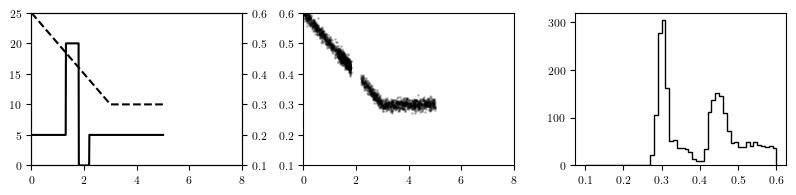

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(8, 2))

sfr_param  = {'sfr0': 5.,
              'gap': (2, 0.4),
              'burst': (2-0.4/2.-0.5/2., 0.5, 20),
              'tmax': 5}

chem_param = {'t0': 3.,
              'MgFe0': 0.3,
              'slope': -0.1,
              'sigma': 0.01}

tlist, sfrlist, MgFelist, tform_samples, MgFe_samples = get_data(sfr_param, chem_param)

axs[0].plot(tlist, sfrlist, c='k', label='SFR')
axs[0].set(xlim=(0, 8), ylim=(0, 25))

ax2 = axs[0].twinx()
ax2.plot(tlist, MgFelist, c='k', ls='dashed', label='[Mg/Fe]')
ax2.set(ylim=(0.1, 0.6))

axs[1].scatter(tform_samples, MgFe_samples, s=1, c='k', alpha=0.2)
axs[1].set(ylim=(0.1, 0.6), xlim=(0, 8))

axs[2].hist(MgFe_samples, bins=np.arange(0.1, 0.6+0.01, 0.01), histtype='step', color='k')

fig.tight_layout()

In [22]:
def plot_row(fig, axs, sfr_param, chem_param, plot_obs=False):

    tlist, sfrlist, MgFelist, tform_samples, MgFe_samples = get_data(sfr_param, chem_param)

    axs[0].plot(tlist, sfrlist, c='k', label=r'$\textrm{SFR}$')
    axs[0].set(xlim=(0, 5), ylim=(0, 25), xticks=np.arange(0, 5+1, 1))
    axs[0].set(xlabel=r'$\textrm{time}\,[\,\textrm{Gyr}\,]$', 
               ylabel=r'$\textrm{SFR}\,[\,M_{\odot}/\textrm{yr}\,]$')

    ax2 = axs[0].twinx()
    ax2.plot(tlist, MgFelist, c='k', ls='dashed', label=r'$[\textrm{Mg}/\textrm{Fe}\,]$')
    ax2.set(ylim=(0.1, 0.6))

    mask = np.random.choice(np.arange(len(MgFe_samples)), int(0.2*len(MgFe_samples)+0.5), replace=False)
    
    axs[1].scatter(tform_samples[mask], MgFe_samples[mask], s=1, c='k', alpha=0.25)
    axs[1].set(ylim=(0.1, 0.6), xlim=(0, 5), xticks=np.arange(0, 5+1, 1))
    axs[1].set(xlabel=r'$\textrm{time}\,[\,\textrm{Gyr}\,]$', 
               ylabel=r'$[\textrm{Mg}/\textrm{Fe}\,]$')

    bins = np.arange(0.2, 0.5+0.01, 0.01)
    axs[2].hist(MgFe_samples, bins=bins, histtype='step', color='k')
    axs[2].set(xlim=(0.1, 0.5), ylim=(0, 500))
    
    bimodal_score = get_bimodality_score_from_MgFe(MgFe_samples)
    axs[2].text(0.4, 400, r'$' + str(round(bimodal_score, 3))+'$')
    # axs[2].yaxis.set_visible(False)
    axs[2].set(xlabel=r'$[\textrm{Mg}/\textrm{Fe}\,]$')
    
    if plot_obs:
        logFeH0 = -0.3
        dlogFeH = 0.1
        mask = np.abs(obsdata['logFeH'] - logFeH0) < dlogFeH/2.
        axs[2].hist(0.5*obsdata['logMgFe'][mask]+0.25, bins=bins, histtype='step', color='r', zorder=0,
                    density=True)
    
    return fig, axs

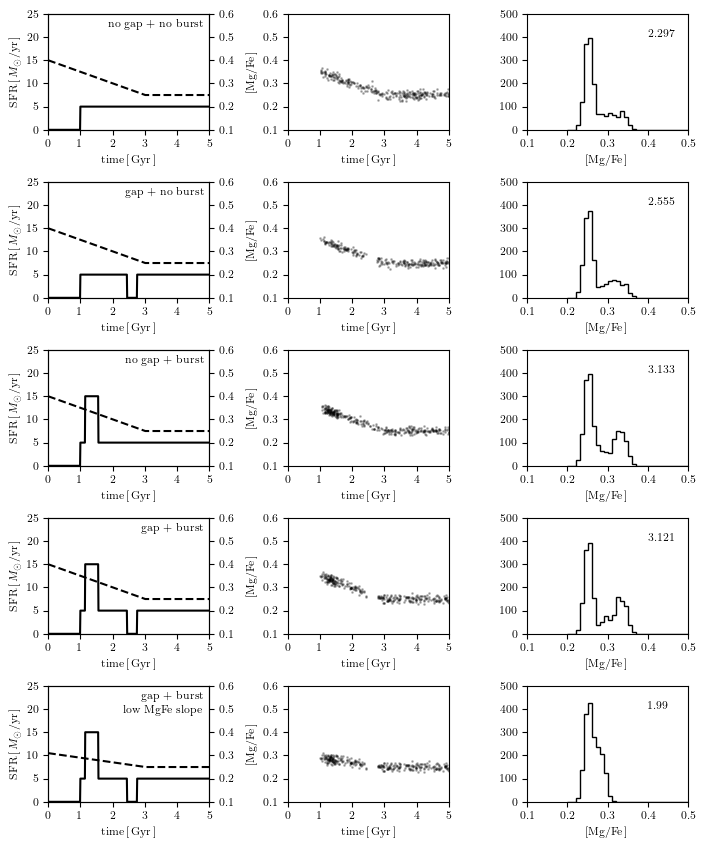

In [27]:
fig, axs = plt.subplots(5, 3, figsize=(textwidth, 1.2*textwidth))

# no gap no burst
sfr_param  = {'sfr0': 5.,
              'gap': None,
              'burst': None,
              'tmax': 6.,
              'tstart': 1}

chem_param = {'t0': 3,
              'MgFe0': 0.25,
              'slope': -0.05,
              'sigma': 0.01}

gap = (2.6, 0.3)
burst = (2-0.4/2.-0.3/2.-0.3, 0.4, 15)

# no gap + no burst
fig, axs[0] = plot_row(fig, axs[0], sfr_param, chem_param)
axs[0][0].text(4.8, 22, r'$\textrm{no gap + no burst}$', horizontalalignment = 'right')

# gap + no burst
sfr_param['gap'] = gap
sfr_param['burst'] = None
fig, axs[1] = plot_row(fig, axs[1], sfr_param, chem_param)
axs[1][0].text(4.8, 22, r'$\textrm{gap + no burst}$', horizontalalignment = 'right')

# no gap + burst
sfr_param['gap'] = None
sfr_param['burst'] = burst
fig, axs[2] = plot_row(fig, axs[2], sfr_param, chem_param)
axs[2][0].text(4.8, 22, r'$\textrm{no gap + burst}$', horizontalalignment = 'right')

# gap + burst
sfr_param['gap'] = gap
sfr_param['burst'] = burst
fig, axs[3] = plot_row(fig, axs[3], sfr_param, chem_param)
axs[3][0].text(4.8, 22, r'$\textrm{gap + burst}$', horizontalalignment = 'right')

# gap + burst + slow MgFe evol
sfr_param['gap'] = gap
sfr_param['burst'] = burst
chem_param['slope'] = -0.02
fig, axs[4] = plot_row(fig, axs[4], sfr_param, chem_param)
axs[4][0].text(4.8, 22, r'$\textrm{gap + burst}$', horizontalalignment = 'right')
axs[4][0].text(4.8, 19, r'$\textrm{low MgFe slope}$', horizontalalignment = 'right')

fig.tight_layout()
fig.savefig('toy_model.pdf')

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [48]:
# Plot function
def plot_interactive(sfr0, tmax, MgFe0, slope, sigma, gap_cen, gap_width, burst_cen, burst_width, burst_amp):
    sfr_param = {
        'sfr0': sfr0,
        'gap': (gap_cen, gap_width),
        'burst': (burst_cen, burst_width, burst_amp),
        'tmax': tmax,
        'tstart': 1
    }
    
    chem_param = {
        't0': 3,
        'MgFe0': MgFe0,
        'slope': slope,
        'sigma': sigma
    }

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    tlist, sfrlist, MgFelist, tform_samples, MgFe_samples = get_data(sfr_param, chem_param)
    
    # First panel: SFR over time
    axs[0].plot(tlist, sfrlist, c='k', label='SFR')
    axs[0].set(xlim=(0, 5), ylim=(0, 25), xlabel='Time [Gyr]', ylabel='SFR [Msun/yr]')
    
    ax2 = axs[0].twinx()
    ax2.plot(tlist, MgFelist, c='k', ls='dashed', label='[Mg/Fe]')
    ax2.set(ylim=(0.1, 0.6))

    # Second panel: Scatter plot of star formation samples
    mask = np.random.choice(np.arange(len(MgFe_samples)), int(0.2 * len(MgFe_samples) + 0.5), replace=False)
    axs[1].scatter(tform_samples[mask], MgFe_samples[mask], s=1, c='k', alpha=0.25)
    axs[1].set(ylim=(0.1, 0.6), xlim=(0, 5), xlabel='Time [Gyr]', ylabel='[Mg/Fe]')

    # Third panel: Histogram of MgFe samples
    bins = np.arange(0.2, 0.5+0.01, 0.01)
    axs[2].hist(MgFe_samples, bins=bins, histtype='step', color='k')
    axs[2].set(xlim=(0.1, 0.5), ylim=(0, 500), xlabel='[Mg/Fe]')
    
    # bimodal_score = get_bimodality_score_from_MgFe(MgFe_samples)
    # axs[2].text(0.4, 400, f'Bimodal Score: {round(bimodal_score, 3)}')

    plt.tight_layout()
    plt.show()

# Interactive widgets
interactive_plot = widgets.interactive(
    plot_interactive,
    sfr0=widgets.FloatSlider(min=1, max=20, step=0.5, value=5, description='SFR_0'),
    tmax=6,
    MgFe0=widgets.FloatSlider(min=0.1, max=0.5, step=0.01, value=0.25, description='MgFe_0'),
    slope=widgets.FloatSlider(min=-0.1, max=0, step=0.01, value=-0.05, description='Slope'),
    sigma=widgets.FloatSlider(min=0.001, max=0.05, step=0.001, value=0.01, description='Sigma'),
    gap_cen=widgets.FloatSlider(min=1., max=5., step=0.01, value=2.6, description='gap center'),
    gap_width=widgets.FloatSlider(min=0., max=2., step=0.1, value=0.3, description='gap width'),
    burst_cen=widgets.FloatSlider(min=1., max=5., step=0.01, value=1.35, description='burst center'),
    burst_width=widgets.FloatSlider(min=0., max=2., step=0.1, value=0.4, description='burst width'),
    burst_amp=widgets.FloatSlider(min=0., max=30, step=1, value=15, description='burst amp'),
)

# Display interactive plot
display(interactive_plot)

interactive(children=(FloatSlider(value=5.0, description='SFR_0', max=20.0, min=1.0, step=0.5), IntSlider(valu…

In [47]:
gap = (2.6, 0.3)
burst = (2-0.4/2.-0.3/2.-0.3, 0.4, 15)
print(burst)

(1.35, 0.4, 15)


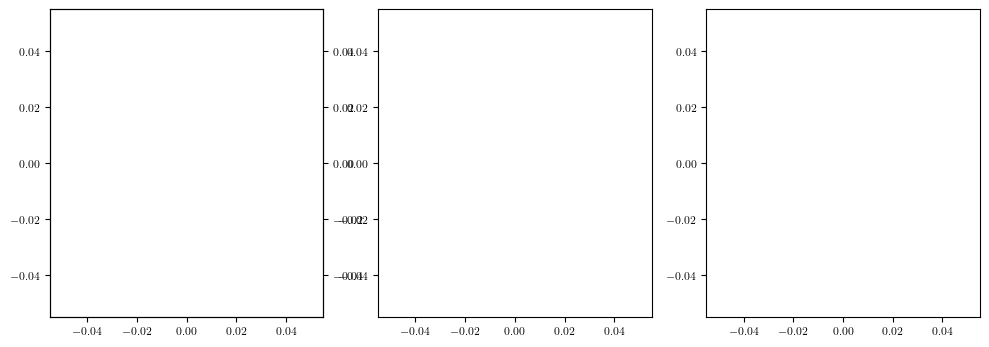

interactive(children=(FloatSlider(value=5.0, description='SFR₀', max=20.0, min=1.0, step=0.5), FloatSlider(val…

In [39]:
# Create figure and axes (only once)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
ax2 = axs[0].twinx()

# Initial empty plots
sfr_line, = axs[0].plot([], [], c='k', label="SFR")
mgfe_line, = ax2.plot([], [], c='k', ls='dashed', label="[Mg/Fe]")
scatter = axs[1].scatter([], [], s=1, c='k', alpha=0.25)
hist_bars = axs[2].bar([], [])  # Empty bars for histogram

# Function to update plots dynamically
def update_plot(sfr0, tmax, MgFe0, slope, sigma, gap_cen, gap_width, burst_cen, burst_width, burst_amp):
    sfr_param = {
        'sfr0': sfr0,
        'gap': (gap_cen, gap_width),
        'burst': (burst_cen, burst_width, burst_amp),
        'tmax': tmax,
        'tstart': 1
    }
    
    chem_param = {
        't0': 3,
        'MgFe0': MgFe0,
        'slope': slope,
        'sigma': sigma
    }

    # Get new data
    tlist, sfrlist, MgFelist, tform_samples, MgFe_samples = get_data(sfr_param, chem_param)

    # Update line plots
    sfr_line.set_data(tlist, sfrlist)
    mgfe_line.set_data(tlist, MgFelist)
    axs[0].set_xlim(0, 5)
    axs[0].set_ylim(0, 25)
    ax2.set_ylim(0.1, 0.6)

    # Update scatter plot
    mask = np.random.choice(np.arange(len(MgFe_samples)), int(0.2 * len(MgFe_samples) + 0.5), replace=False)
    scatter.set_offsets(np.column_stack([tform_samples[mask], MgFe_samples[mask]]))

    # Update histogram
    bins = np.arange(0.2, 0.5+0.01, 0.01)
    hist_vals, _ = np.histogram(MgFe_samples, bins=bins)
    
    for rect, h in zip(hist_bars, hist_vals):
        rect.set_height(h)

    axs[2].set_xlim(0.1, 0.5)
    axs[2].set_ylim(0, 500)

    # Refresh canvas
    fig.canvas.draw_idle()

# Interactive widgets
interactive_plot = widgets.interactive(
    update_plot,
    sfr0=widgets.FloatSlider(min=1, max=20, step=0.5, value=5, description="SFR₀"),
    tmax=widgets.FloatSlider(min=1, max=10, step=0.5, value=6, description="tmax"),
    MgFe0=widgets.FloatSlider(min=0.1, max=0.5, step=0.01, value=0.25, description="MgFe₀"),
    slope=widgets.FloatSlider(min=-0.1, max=0, step=0.01, value=-0.05, description="Slope"),
    sigma=widgets.FloatSlider(min=0.001, max=0.05, step=0.001, value=0.01, description="Sigma"),
    gap_cen=widgets.FloatSlider(min=1., max=5., step=0.01, value=2.5, description="gap center"),
    gap_width=widgets.FloatSlider(min=0., max=2., step=0.1, value=0.3, description="gap width"),
    burst_cen=widgets.FloatSlider(min=1., max=5., step=0.01, value=1.5, description="burst center"),
    burst_width=widgets.FloatSlider(min=0., max=2., step=0.1, value=0.3, description="burst width"),
    burst_amp=widgets.FloatSlider(min=0., max=30, step=1, value=15, description="burst amp"),
)

# Display interactive plot
display(interactive_plot)

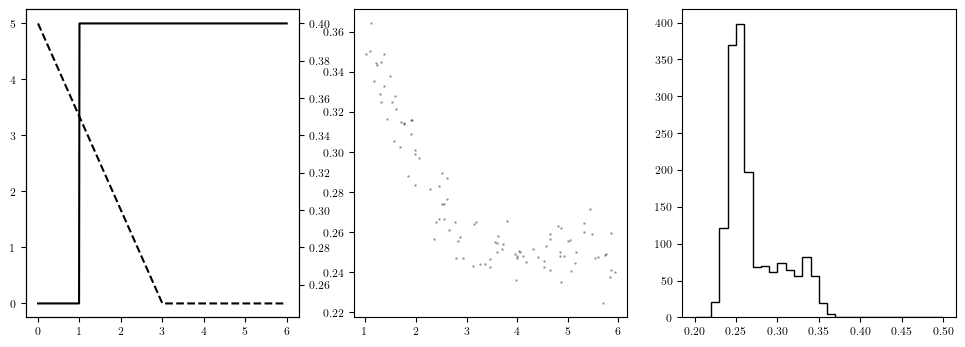

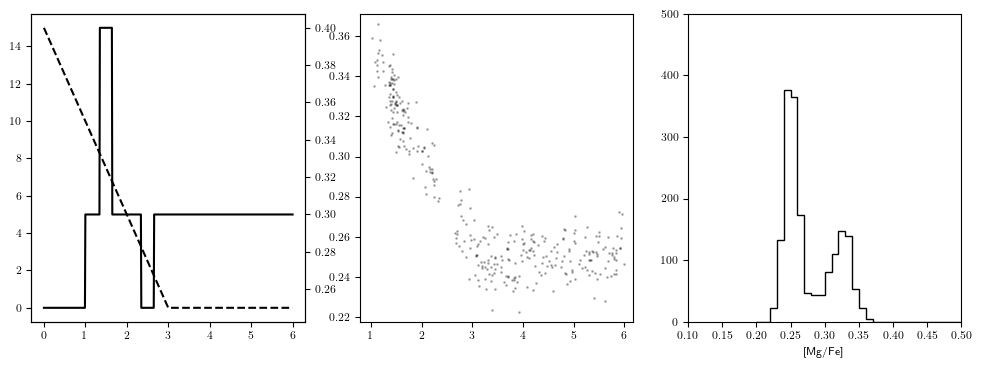

Output()

In [46]:
# Create figure and axes (only once)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
ax2 = axs[0].twinx()

# Generate initial data
tlist, sfrlist, MgFelist, tform_samples, MgFe_samples = get_data(
    {'sfr0': 5, 'gap': None, 'burst': None, 'tmax': 6, 'tstart': 1},
    {'t0': 3, 'MgFe0': 0.25, 'slope': -0.05, 'sigma': 0.01}
)

# Initialize plots
sfr_line, = axs[0].plot(tlist, sfrlist, c='k', label="SFR")
mgfe_line, = ax2.plot(tlist, MgFelist, c='k', ls='dashed', label="[Mg/Fe]")

scatter = axs[1].scatter(tform_samples[:100], MgFe_samples[:100], s=1, c='k', alpha=0.25)

bins = np.arange(0.2, 0.5 + 0.01, 0.01)
axs[2].hist(MgFe_samples, bins=bins, histtype='step', color='k')

# Function to update plots dynamically
def update_plot(sfr0, tmax, MgFe0, slope, sigma, gap_cen, gap_width, burst_cen, burst_width, burst_amp):
    sfr_param = {
        'sfr0': sfr0,
        'gap': (gap_cen, gap_width),
        'burst': (burst_cen, burst_width, burst_amp),
        'tmax': tmax,
        'tstart': 1
    }
    
    chem_param = {
        't0': 3,
        'MgFe0': MgFe0,
        'slope': slope,
        'sigma': sigma
    }

    # Get new data
    tlist, sfrlist, MgFelist, tform_samples, MgFe_samples = get_data(sfr_param, chem_param)

    # Update line plots
    sfr_line.set_data(tlist, sfrlist)
    mgfe_line.set_data(tlist, MgFelist)
    axs[0].relim()
    axs[0].autoscale_view()
    ax2.relim()
    ax2.autoscale_view()

    # Update scatter plot
    mask = np.random.choice(len(MgFe_samples), int(0.2 * len(MgFe_samples)), replace=False)
    scatter.set_offsets(np.column_stack([tform_samples[mask], MgFe_samples[mask]]))

    # Update histogram
    axs[2].cla()  # Clear previous histogram
    axs[2].hist(MgFe_samples, bins=bins, histtype='step', color='k')
    axs[2].set_xlim(0.1, 0.5)
    axs[2].set_ylim(0, 500)
    axs[2].set_xlabel("[Mg/Fe]")

    # Refresh canvas
    fig.canvas.draw_idle()

# Interactive widgets
controls = {
    "sfr0": widgets.FloatSlider(min=1, max=20, step=0.5, value=5, description="SFR₀"),
    "tmax": widgets.FloatSlider(min=1, max=10, step=0.5, value=6, description="tmax"),
    "MgFe0": widgets.FloatSlider(min=0.1, max=0.5, step=0.01, value=0.25, description="MgFe₀"),
    "slope": widgets.FloatSlider(min=-0.1, max=0, step=0.01, value=-0.05, description="Slope"),
    "sigma": widgets.FloatSlider(min=0.001, max=0.05, step=0.001, value=0.01, description="Sigma"),
    "gap_cen": widgets.FloatSlider(min=1., max=5., step=0.01, value=2.5, description="gap center"),
    "gap_width": widgets.FloatSlider(min=0., max=2., step=0.1, value=0.3, description="gap width"),
    "burst_cen": widgets.FloatSlider(min=1., max=5., step=0.01, value=1.5, description="burst center"),
    "burst_width": widgets.FloatSlider(min=0., max=2., step=0.1, value=0.3, description="burst width"),
    "burst_amp": widgets.FloatSlider(min=0., max=30, step=1, value=15, description="burst amp"),
}

# Use interactive_output to link widgets to the update function
interactive_output = widgets.interactive_output(update_plot, controls)

# Display the figure and controls
display(fig)
display(interactive_output, widgets.VBox(list(controls.values())))